# 프로젝트: CutMix 또는 Mixup 비교실험 하기

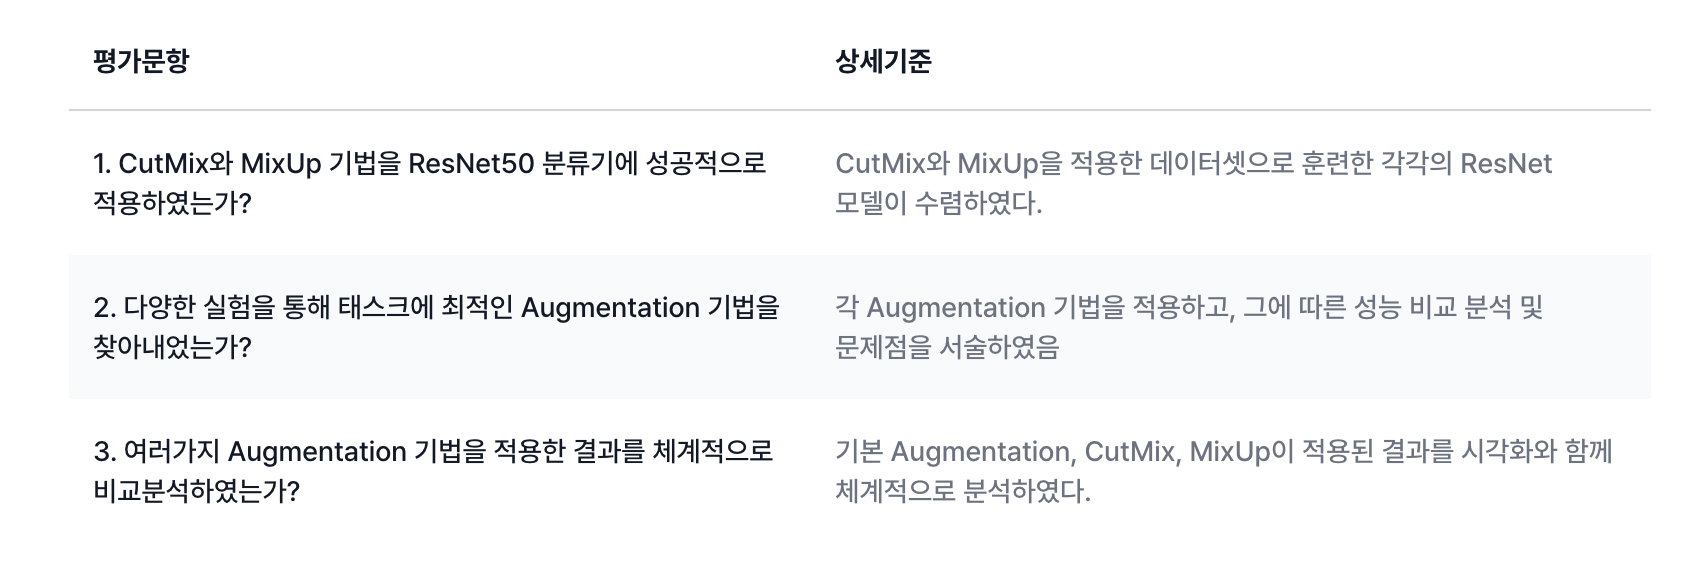

In [1]:
# 라이브러리 버전 확인
import tensorflow as tf
import numpy as np

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Augmentation을 적용한 데이터셋 만들기

In [2]:
#as supervised -> tuple 형태
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

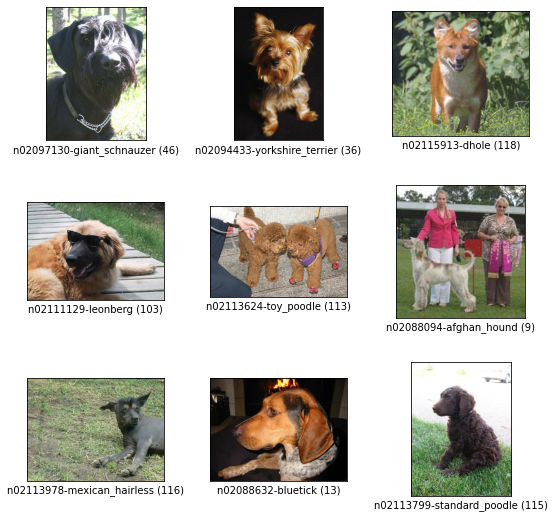

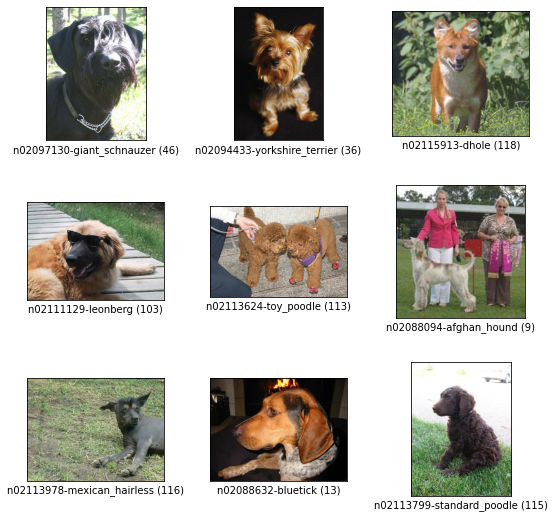

In [4]:
tfds.show_examples(ds_train, ds_info)

In [4]:
# feature 정보 확인
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


In [3]:
# 클래스의 개수 확인
num_classes = ds_info.features["label"].num_classes
print('class 개수 :', num_classes)

class 개수 : 120


In [12]:
print(image_a.shape, label_a.shape)

(224, 224, 3) (120,)


In [4]:
# b의 bounding box 추출하여 a에 적용 (바탕 = a)
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max


In [5]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img


In [6]:
# mix two labels

def mix_2_labels(image, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image.shape[1]
    image_size_y = image.shape[0] 
    
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)
    
    # one-hot 적용
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_label

In [7]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a,label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [8]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


In [9]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [10]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    
    # 배치정렬
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
        
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
        
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

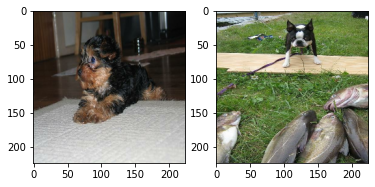

In [15]:
# 데이터셋에서 이미지 2개를 가져오기
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [16]:
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(69, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(85, shape=(), dtype=int32)


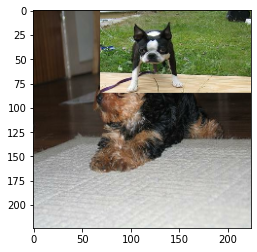

In [17]:
mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [18]:
mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.73742425, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.26257575,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

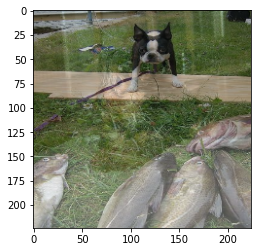

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.3773086 0.        0.        0.        0.        0.
 0.        0.        0.6226914 0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [19]:
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [12]:
ds_train_no_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)

ds_train_no_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=False, with_mixup=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## 2. 모델 만들기 - ResNet50

In [13]:
# ResNet50 중 imagenet으로 훈련된 모델을 호출, include_top은 마지막 fully connected layer를 포함할지 여부
num_classes = ds_info.features["label"].num_classes

# 기본 데이터셋 학습할 모델
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

#데이터 증강셋 학습할 모델
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# 원본 + cutmix 데이터셋 학습할 모델
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# 증강 + cutmix 증강셋 학습할 모델
aug_resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# 원본 + mixup 데이터셋 학습할 모델
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# 증강 + mixuo 증강셋 학습할 모델
aug_resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## 3. 모델 훈련하기

In [15]:
BATCH_SIZE = 16
EPOCH = 10

In [25]:
# 기본 데이터셋
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50 = resnet50.fit(
    ds_train_no_aug, # no aug data
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 157s 200ms/step - loss: 2.1544 - accuracy: 0.4608 - val_loss: 3.3067 - val_accuracy: 0.2179
Epoch 2/10
750/750 [==============================] - 152s 202ms/step - loss: 0.7436 - accuracy: 0.7915 - val_loss: 1.0462 - val_accuracy: 0.6924
Epoch 3/10
750/750 [==============================] - 152s 203ms/step - loss: 0.2551 - accuracy: 0.9442 - val_loss: 0.9299 - val_accuracy: 0.7266
Epoch 4/10
750/750 [==============================] - 152s 203ms/step - loss: 0.0710 - accuracy: 0.9931 - val_loss: 0.8989 - val_accuracy: 0.7390
Epoch 5/10
750/750 [==============================] - 152s 203ms/step - loss: 0.0278 - accuracy: 0.9987 - val_loss: 0.8946 - val_accuracy: 0.7431
Epoch 6/10
750/750 [==============================] - 167s 223ms/step - loss: 0.0179 - accuracy: 0.9996 - val_loss: 0.9021 - val_accuracy: 0.7472
Epoch 7/10
750/750 [==============================] - 152s 203ms/step - loss: 0.0141 - accuracy: 0.9995 - val_loss: 0.9276 -

In [26]:
# aug

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # aug_data
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 157s 200ms/step - loss: 2.2748 - accuracy: 0.4346 - val_loss: 3.2054 - val_accuracy: 0.2352
Epoch 2/10
750/750 [==============================] - 152s 202ms/step - loss: 0.9784 - accuracy: 0.7168 - val_loss: 1.3775 - val_accuracy: 0.6023
Epoch 3/10
750/750 [==============================] - 152s 202ms/step - loss: 0.5117 - accuracy: 0.8590 - val_loss: 1.0637 - val_accuracy: 0.6958
Epoch 4/10
750/750 [==============================] - 152s 202ms/step - loss: 0.2732 - accuracy: 0.9348 - val_loss: 1.0900 - val_accuracy: 0.6867
Epoch 5/10
750/750 [==============================] - 152s 202ms/step - loss: 0.1496 - accuracy: 0.9696 - val_loss: 1.0379 - val_accuracy: 0.7095
Epoch 6/10
750/750 [==============================] - 152s 202ms/step - loss: 0.0863 - accuracy: 0.9860 - val_loss: 0.9354 - val_accuracy: 0.7343
Epoch 7/10
750/750 [==============================] - 152s 202ms/step - loss: 0.0590 - accuracy: 0.9909 - val_loss: 0.9763 -

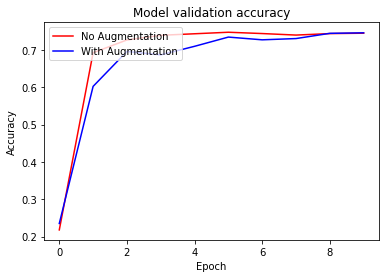

In [27]:
plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

In [16]:
# no aug + cutmix

resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_no_aug_cutmix,  
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 221s 224ms/step - loss: 3.8503 - accuracy: 0.2047 - val_loss: 3.5208 - val_accuracy: 0.1875
Epoch 2/10
750/750 [==============================] - 154s 206ms/step - loss: 2.9526 - accuracy: 0.4254 - val_loss: 1.7104 - val_accuracy: 0.5375
Epoch 3/10
750/750 [==============================] - 154s 206ms/step - loss: 2.6425 - accuracy: 0.5299 - val_loss: 1.2545 - val_accuracy: 0.6540
Epoch 4/10
750/750 [==============================] - 169s 226ms/step - loss: 2.4406 - accuracy: 0.5968 - val_loss: 1.2607 - val_accuracy: 0.6536
Epoch 5/10
750/750 [==============================] - 154s 206ms/step - loss: 2.2731 - accuracy: 0.6503 - val_loss: 1.2524 - val_accuracy: 0.6635
Epoch 6/10
750/750 [==============================] - 154s 205ms/step - loss: 2.1762 - accuracy: 0.6780 - val_loss: 1.2038 - val_accuracy: 0.6761
Epoch 7/10
750/750 [==============================] - 154s 206ms/step - loss: 2.0490 - accuracy: 0.7170 - val_loss: 1.1612 -

In [17]:
# aug + cutmix

aug_resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = aug_resnet50_cutmix.fit(
    ds_train_aug_cutmix,  
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 162s 205ms/step - loss: 3.8815 - accuracy: 0.1986 - val_loss: 3.4406 - val_accuracy: 0.1960
Epoch 2/10
750/750 [==============================] - 154s 205ms/step - loss: 3.0257 - accuracy: 0.4095 - val_loss: 1.4519 - val_accuracy: 0.6032
Epoch 3/10
750/750 [==============================] - 154s 205ms/step - loss: 2.7365 - accuracy: 0.4897 - val_loss: 1.3464 - val_accuracy: 0.6305
Epoch 4/10
750/750 [==============================] - 154s 205ms/step - loss: 2.5569 - accuracy: 0.5464 - val_loss: 1.5462 - val_accuracy: 0.5843
Epoch 5/10
750/750 [==============================] - 154s 205ms/step - loss: 2.4154 - accuracy: 0.5955 - val_loss: 1.2219 - val_accuracy: 0.6632
Epoch 6/10
750/750 [==============================] - 154s 205ms/step - loss: 2.3126 - accuracy: 0.6264 - val_loss: 1.2159 - val_accuracy: 0.6644
Epoch 7/10
750/750 [==============================] - 154s 205ms/step - loss: 2.2319 - accuracy: 0.6608 - val_loss: 1.1399 -

In [18]:
# no aug + mixup

resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_no_aug_mixup,  
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 160s 204ms/step - loss: 3.7166 - accuracy: 0.2427 - val_loss: 3.5992 - val_accuracy: 0.1962
Epoch 2/10
750/750 [==============================] - 155s 206ms/step - loss: 2.8756 - accuracy: 0.4736 - val_loss: 1.5789 - val_accuracy: 0.5663
Epoch 3/10
750/750 [==============================] - 154s 206ms/step - loss: 2.5800 - accuracy: 0.5843 - val_loss: 1.6009 - val_accuracy: 0.5615
Epoch 4/10
750/750 [==============================] - 154s 206ms/step - loss: 2.3978 - accuracy: 0.6515 - val_loss: 1.4289 - val_accuracy: 0.6088
Epoch 5/10
750/750 [==============================] - 154s 206ms/step - loss: 2.2587 - accuracy: 0.7122 - val_loss: 1.3284 - val_accuracy: 0.6351
Epoch 6/10
750/750 [==============================] - 170s 227ms/step - loss: 2.1507 - accuracy: 0.7516 - val_loss: 1.2303 - val_accuracy: 0.6722
Epoch 7/10
750/750 [==============================] - 155s 206ms/step - loss: 2.0724 - accuracy: 0.7748 - val_loss: 1.1766 -

In [19]:
# aug + mixup

aug_resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mixup = aug_resnet50_mixup.fit(
    ds_train_aug_mixup,  
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 161s 204ms/step - loss: 3.7468 - accuracy: 0.2315 - val_loss: 3.3586 - val_accuracy: 0.2181
Epoch 2/10
750/750 [==============================] - 154s 206ms/step - loss: 2.9442 - accuracy: 0.4462 - val_loss: 1.5786 - val_accuracy: 0.5592
Epoch 3/10
750/750 [==============================] - 154s 205ms/step - loss: 2.6961 - accuracy: 0.5353 - val_loss: 1.3609 - val_accuracy: 0.6238
Epoch 4/10
750/750 [==============================] - 154s 206ms/step - loss: 2.5433 - accuracy: 0.5982 - val_loss: 1.5806 - val_accuracy: 0.5711
Epoch 5/10
750/750 [==============================] - 154s 206ms/step - loss: 2.4032 - accuracy: 0.6426 - val_loss: 1.3435 - val_accuracy: 0.6279
Epoch 6/10
750/750 [==============================] - 170s 226ms/step - loss: 2.3214 - accuracy: 0.6798 - val_loss: 1.3062 - val_accuracy: 0.6363
Epoch 7/10
750/750 [==============================] - 154s 206ms/step - loss: 2.2295 - accuracy: 0.7113 - val_loss: 1.1969 -

## 4. Augmentation에 의한 모델 성능 비교

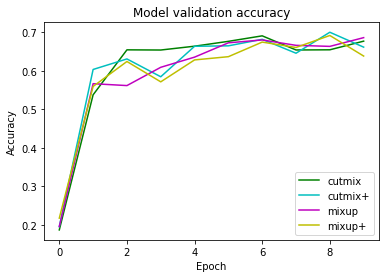

In [22]:
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'c')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'y')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['cutmix', 'cutmix+', 'mixup', 'mixup+'], loc='lower right')
plt.show()

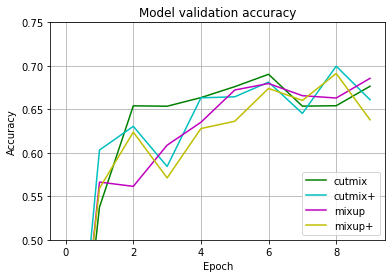

In [24]:
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'c')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'y')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['cutmix', 'cutmix+', 'mixup', 'mixup+'], loc='lower right')

#확대해서 그려보자.
plt.grid(True)
plt.ylim(0.50, 0.75)    # 출력하고자 하는  Accuracy 범위를 지정. 50~75 %
plt.show()

## 5. conclusion

이번 실험은 모델을 고정하고, 데이터의 크기를 늘려(augmentation, 노이즈 적용) 모델 성능에 어떠한 영향을 미치는 지 알고자 했다.  

resnet50에 batch_size 16, 에포크 10을 기준으로 (stanford_dogs)dog classification task에서 가장 좋은 성능을 내는  

데이터 augmentation은 다음과 같은 순서를 가진다.  

1. base aug
2. base
3. mixup
4. cutmix
5. cutmux aug
6. mixup aug


## 6. 회고하기

1. mixup / cutmix 학습이 이뤄지지 않는데, 어떤 종류의 문제가 발생한 건지 알 수가 없어 수정할 수가 없었다.    
   -> image / label을 generate하는 함수에서 겹치는 코드가 생겼다. 이를 해결하여 모델 학습이 이뤄졌다.

2. ds.take()로 이미지 샘플을 시각화 해보는 작업이 필요할 것 같다.  
   -> 코드를 작성하여 이미지 샘플의 aug가 됐는지 직접 확인 할 수 있었다.  

3. 이미지 샘플을 시각화 해봤으면 해당 이미지에 대한 image histogram을 추출하여 비교해볼 것.